In [41]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
from open_data  import matlab_file
from structure_data import  structure
from compute.classif import classify

import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms

import os
import sys

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load data

In [42]:
lab_desktop = True

measure = 'ID'
classif = 'HistGrad'

if lab_desktop : 
    session = 't150204001'
    data_path = f'/home/INT/mifsud.l/Bureau/data/Tommy/{session}/modified_data/' #f'~/Bureau/data/Tommy/{session}/modified_data'
    info_path = '/home/INT/mifsud.l/Bureau/Lists&Documentation/TomyCerebusSpikes_Updated_June2023.xlsx'
    result_path = '~/Bureau/results'

else : 
    session = 't150204001'
    data_path = f'/home/laurie/Bureau/pattern_classification/data/Tommy_new/{session}/modified_data/'
    info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/session_info.xlsx'

print(f'session : {session}')

session : t150204001


In [43]:
# import data from matlab file
data, load_info = matlab_file.open(data_path)
# clean data 
df = matlab_file.clean(info_path)
# get sessions and units info 
info_units,  info_session = structure.info(load_info, df, session)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(structure.elitrials)
print(info_session.shape)

# get unit's index without eli trials 
completeUnit = structure.CompleteTasktime(info_session, load_info, session)


43 files loaded


(45, 8)
     start  stop elitrials
159      1    11      None 

unit_info : [1 3 1]
t150204001_probe1_contact3_unit1.mat

unit's loading index = 2


In [44]:
# extract data from the matlab file
spike_times = matlab_file.extract_spike_times(load_info, data)
task_data = matlab_file.extract_task_data(load_info, data, target_keys=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

target_info = matlab_file.extract_target_info(load_info, data, target_keys=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])
# get trials indices per condition
target_1 = np.where(target_info[completeUnit][1]['Trial_type'] == 1)[0]
target_2 = np.where(target_info[completeUnit][1]['Trial_type'] == 2)[0]
target_3 = np.where(target_info[completeUnit][1]['Trial_type'] == 3)[0]

event_labels = matlab_file.get_event_labels(task_data)
event_times = matlab_file.get_event_times(task_data, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = structure.events_by_trial(event_times, event_labels)

unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {target_info[0][1].keys()}')



times as list : [3047992 3049069 3050391 3051713 3053021 3054320 3054799]
times as neo events : [3047992. 3049069. 3050391. 3051713. 3053021. 3054320. 3054799.] ms
spike train sample : [    237    2137    3267 ... 3657198 3657250 3658579]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])


In [78]:
# get target by trial and neuron
n_units = len(target_info)

list_trial_type = []
list_position = []
list_type_and_pos = []

for unit in range(n_units):
    #print(f'neuron {unit}')
    list_trial_type.append([])
    list_position.append([])
    list_type_and_pos.append([])
    trial_type = target_info[unit][1]['Trial_type']
    n_trials = trial_type.shape[0]

    for trial in range(n_trials):
        #print(f'trial type : {trial_type[trial]}')
        valid_cue_idx = target_info[unit][1]['Trial_type'][trial] - 1
        valid_cue = list(target_info[unit][1].keys())[valid_cue_idx]
        position = target_info[unit][1][f'{valid_cue}'][trial]
        #print(f'position : {position}')
        list_trial_type[unit] = list(trial_type)
        list_position[unit].append(position)

    cue_position = list(zip(list_trial_type[unit], list_position[unit]))
    cue_pos_combinations = sorted(set(cue_position))

    # build the target accoring the combination of the cue/direction
    cue_and_pos = []
    for sel_cue, direction in cue_position:
        cue_and_pos.append(cue_pos_combinations.index((sel_cue, direction)))

    list_type_and_pos[unit] = cue_and_pos

# Data formating

In [45]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


# units labels

In [46]:
def unit_label(info_units): 
    info_units_df = pd.DataFrame(info_units)
    count_unitProbe = list(info_units_df['probe'].value_counts(sort=False))

    n_units = len(spike_times)
    n_event = event_labels[:-1]

    unit_label = []
    unit_labelProbe1 = []
    unit_labelProbe2 = []

    for i in range(n_units):
        label = str(\
            'P' + str(info_units[i]['probe']) \
            + '-' + str(info_units[i]['contact']) \
            + '-' + str(info_units[i]['unit'])) 
        unit_label.append(label)

        if info_units[i]['probe'] == 1 :
            unit_labelProbe1.append(label)
        else : 
            unit_labelProbe2.append(label)

    return unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe

unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = unit_label(info_units)
print(len(unit_labelProbe1) == count_unitProbe[0])
print(len(unit_labelProbe2) == count_unitProbe[1])
unit_labelTwoprobes = unit_label

True
True


#  Trials ref 

In [47]:
n_neurons = len(spike_times)
n_trials = df_task_ts.shape[0]
n_events = df_task_ts.shape[1] - 1 

In [48]:
for unit in range(n_neurons) :
    list_idx_trial = []
    times_unit = df_task_ts_by_neuron[unit][1]
    n_trials_unit = times_unit.shape[0]

    for trial in range(n_trials_unit):

        for i, event in enumerate(event_labels[:-1]):
            #print(f'trial :{trial}')            
            t_start = times_unit.loc[trial][f'{event}']
            t_stop = times_unit.loc[trial][f'{event_labels[i+1]}']
            idx_trial = df_task_ts[df_task_ts[f'{event}'] == t_start].index[0]

        list_idx_trial.append(idx_trial)
    df_task_ts_by_neuron[unit][1].insert(0, 'idx_ref_trial', list_idx_trial)


# Spike times formating (alignement, nan for invalid trials)

In [49]:
# get spike by trial for each neuron + Neo format (SpikeTrain)
from neo.core import SpikeTrain

def spike_ts_trial(n_neurons, trials_ts, spike_times):  
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_trials = []
    spike_train = []
    

    for unit_idx in range(n_neurons):
        spk_trials.append([])
        spike_train.append([])

        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            # define the start and end time of each trial
            t_start = trials_ts[unit_idx][1][trial,0]
            t_stop = trials_ts[unit_idx][1][trial,-1]
            
            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit_idx][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            # for trials without spikes 
            if spk_tmp[sel_spk].shape[0] == 0:
                spk_trials[unit_idx].append([])
                spike_train[unit_idx].append([])

            else :
                spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop, dtype='int32')
                # fill the matrice with spike times aligned to 0
                spike_train[unit_idx].append(spk_ts_trial)

    return spk_trials, spike_train
    

spk_trials, spike_train_trial = spike_ts_trial(n_neurons, trials_ts, spike_times)

In [50]:
'''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

def align_trials(df_task_ts, df_task_ts_by_neuron, spike_times):
    n_units = len(spike_times)

    for unit_idx in range(n_units):
        data = df_task_ts_by_neuron[unit_idx][1]
        list_trials_unit = list(data['idx_ref_trial'])

        nan_trials = [item for item in list_trials_task if item not in list_trials_unit]
        valid_trials = [item for item in list_trials_task if item in list_trials_unit]

        for idx_trial_valid, trial_valid in enumerate(valid_trials):
            # define the start and end time of each trial
            t_start = data.loc[idx_trial_valid][1]
            t_stop = data.loc[idx_trial_valid][-1]

            # get spikes between start and end of trial and align to zero
            spk_tmp = spike_times[unit_idx][1]
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            spikes_times_aligned_ = []
                    
            for spk_idx, spk in enumerate(spk_tmp[sel_spk]):
                spk_aligned = spk - t_start
                spikes_times_aligned_.append(spk_aligned)
                        
            spikes_times_aligned[unit_idx][trial_valid]= {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : trial_valid, 
                        't_start_ref' : t_start,
                        't_start_aligned' : t_start - t_start,
                        't_stop_aligned': t_stop - t_start,
                        'spike_time' : np.array(spikes_times_aligned_, dtype=np.int32), 
                        'spike_train' : spike_train_trial[unit_idx][idx_trial_valid]
                        }

        for idx_trial_nan in (nan_trials):
            t_start_nan = df_task_ts.loc[idx_trial_nan][0]
            t_stop_nan = df_task_ts.loc[idx_trial_nan][-1]


            spikes_times_aligned[unit_idx][idx_trial_nan] = {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : idx_trial_nan, 
                        't_start_ref' : t_start_nan, 
                        't_start_aligned' : t_start_nan - t_start_nan,
                        't_stop_aligned': t_stop_nan - t_start_nan,
                        'spike_time' : np.zeros(1, dtype=np.int64),
                        'spike_train' :  np.zeros(1, dtype=np.int64)
                        }

    return spikes_times_aligned
    
list_trials_task = list(df_task_ts.index)
spikes_times_aligned = np.zeros((n_neurons, n_trials), dtype=object)
spikes_times_aligned = align_trials(df_task_ts, df_task_ts_by_neuron, spike_times)


/tmp/ipykernel_13212/3040918305.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start = data.loc[idx_trial_valid][1]
/tmp/ipykernel_13212/3040918305.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stop = data.loc[idx_trial_valid][-1]
/tmp/ipykernel_13212/3040918305.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start_nan = df_task_ts.loc[idx_trial_nan][0]
/tmp/ipykernel_13212/3040918305.py:39: FutureWarning: Se

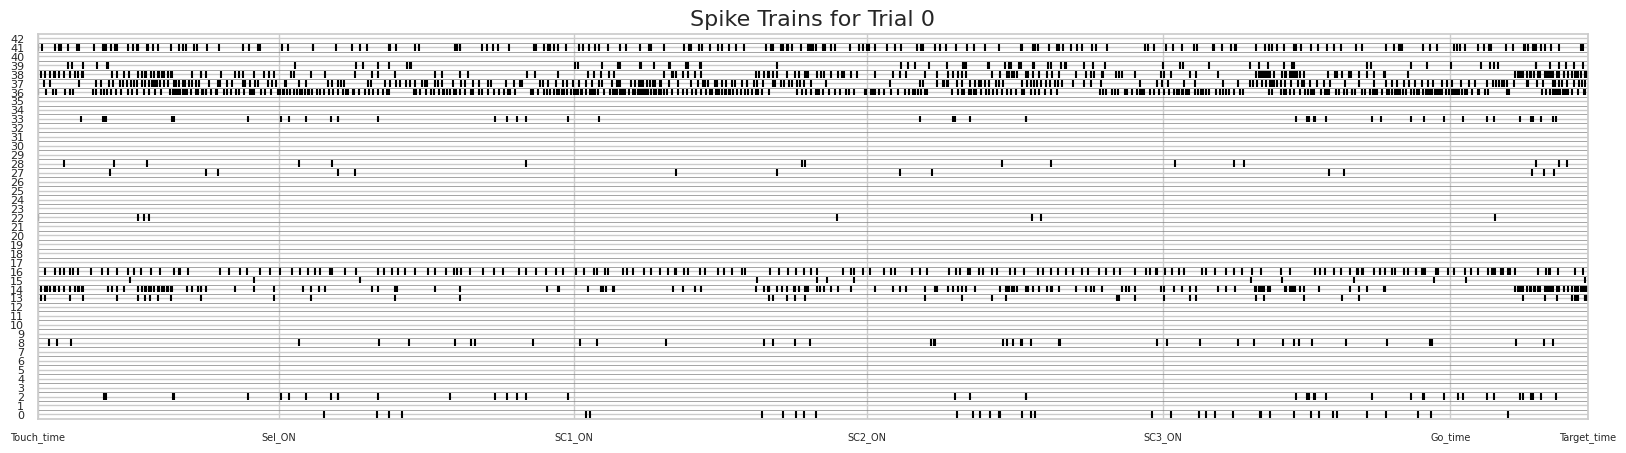

In [51]:
t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(20, 5))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# ISI Draft

In [52]:
from synchrony import ISI

In [53]:
X_isi_ = np.zeros((n_trials), dtype=object)
row, col = np.triu_indices(n_neurons, k=1)
n_pairs = len(row)
ISI_distance = []
X_isi = []

for t in range(n_trials) : 
    n_times = spikes_times_aligned[0][t]['t_stop_aligned']
    X_isi_one_trial = np.zeros((n_neurons, n_times))
    for n in range(n_neurons) :
        x_isi = ISI.compute(spikes_times_aligned[n][t]) 
        X_isi_one_trial[n, :] = x_isi

    ISI_distance_one_trials = np.zeros((n_pairs, n_times))
    for n_p, (r,c) in enumerate(zip(row, col)):
        ISI_distance_one_trials[n_p,:] = ISI.distance(X_isi_one_trial[r, :], X_isi_one_trial[c, :])
    
    X_isi.append(X_isi_one_trial)
    ISI_distance.append(ISI_distance_one_trials)

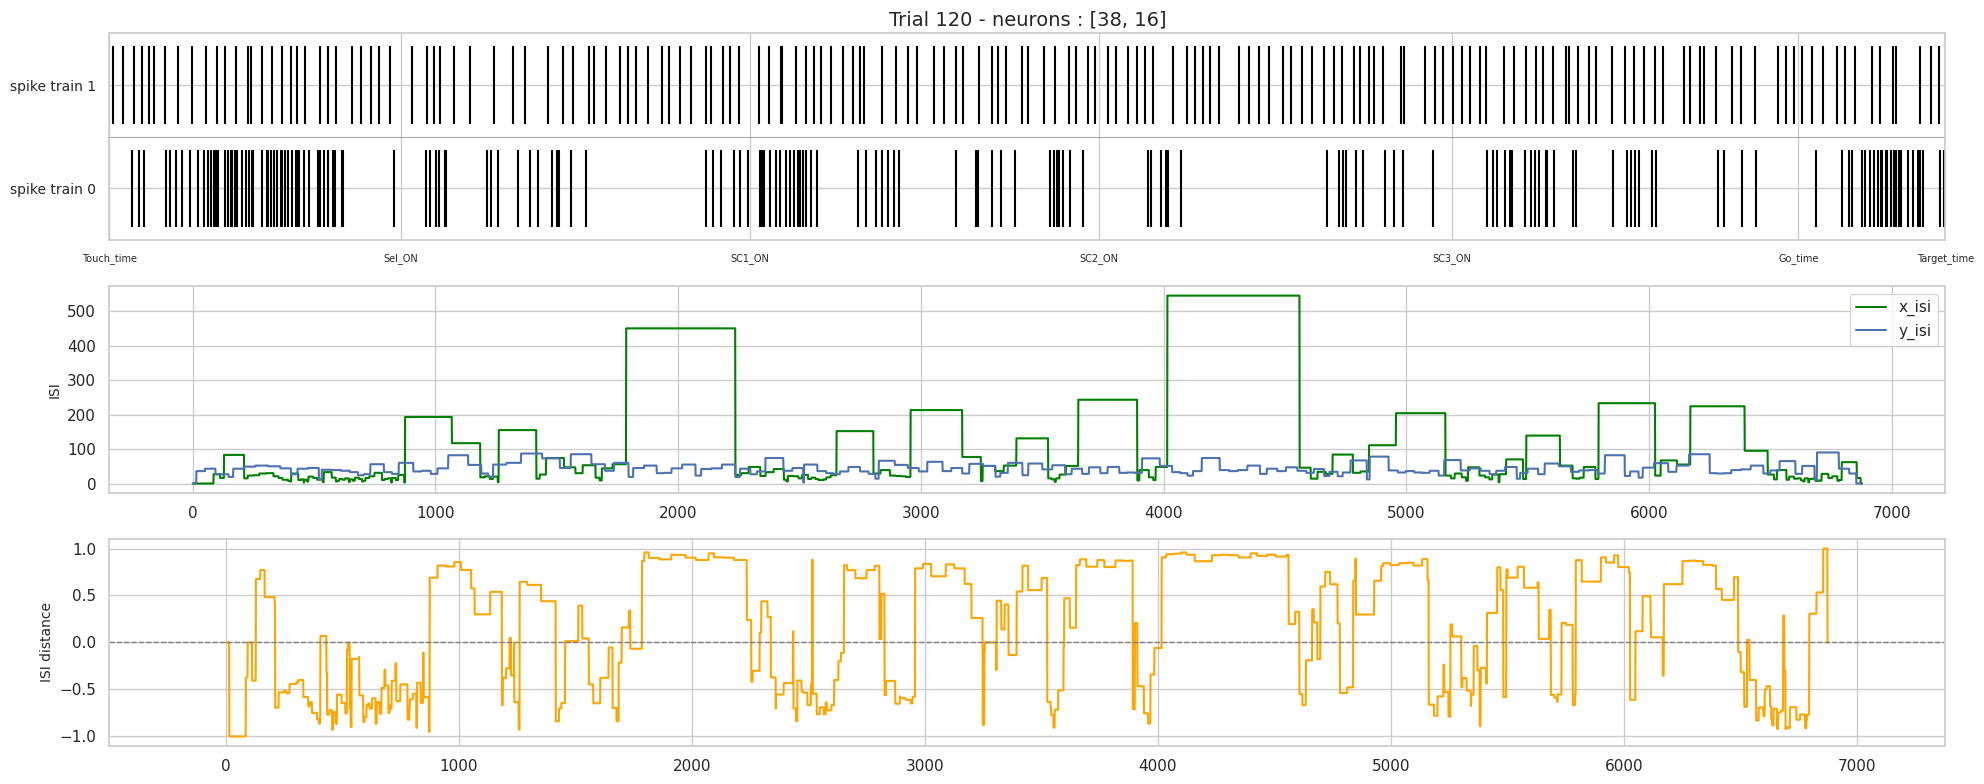

In [54]:
t = 120
neurons_ = [38,16]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) : 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {i}" for i in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

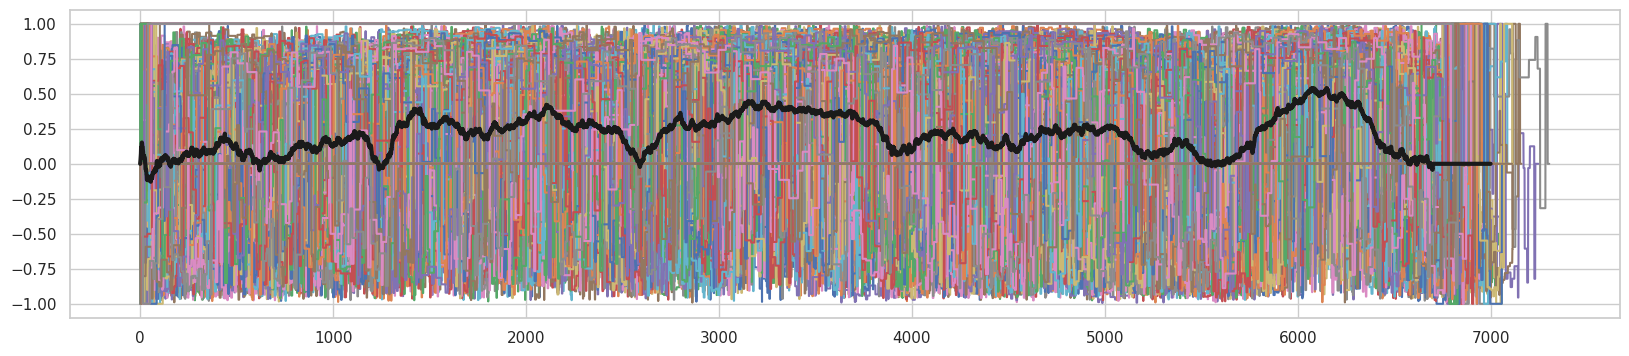

In [55]:
plt.figure(figsize=(20, 4))
ISI_dist_mean = np.zeros([7000])
for t in range(n_trials):
  x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
  y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
  ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)
  ISI_dist_mean[:6700] += ISI_distance_[:6700]

  plt.plot(ISI_distance_)  
plt.plot(ISI_dist_mean/n_trials, linewidth=3, c='k') 

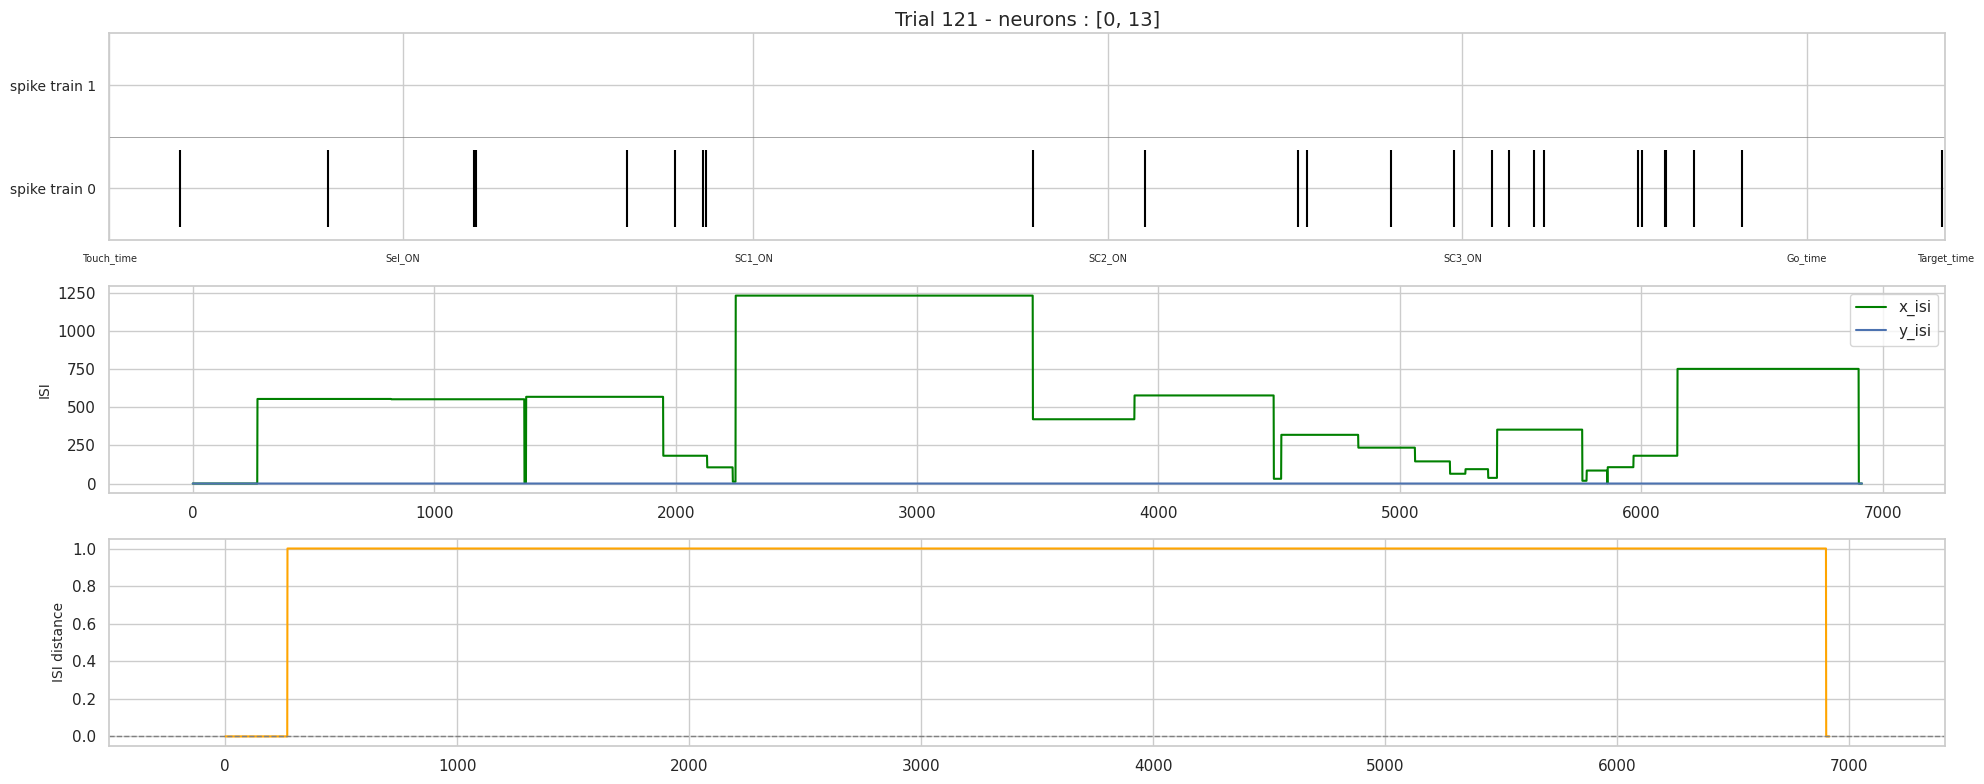

In [56]:
t = 121
neurons_ = [0,13]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()
0
# Plot isi_dist in the second column
axs[2].plot(ISI_distance_, color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_.shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_.shape[0] + 500)  # Set x-axis limits

plt.tight_layout()

# ISI Interpolation

In [57]:
def get_max_length(n_trials, ISI_distance):
    time_ = np.zeros((n_trials), dtype=int)
    for t in range(n_trials): 
        time_[t] = ISI_distance[t].shape[1]
    max_length = np.max(time_)

    return max_length, time_

In [58]:
def interpolate_ISI_distance(ISI_distance,  max_length):
    len_trial = ISI_distance.shape[0]
    ISI_distance_interp_ = np.full(max_length, np.nan)
    ISI_distance_interp_[:len_trial] = ISI_distance
    return ISI_distance_interp_

def interpolate_X_isi(X_isi,  max_length):
    len_trial = X_isi.shape[0]
    X_isi_interp_ = np.full(max_length, np.nan)
    X_isi_interp_ = np.full(max_length, np.nan)
    X_isi_interp_[:len_trial] = X_isi
    return X_isi_interp_

In [59]:
max_length, time = get_max_length(n_trials, ISI_distance)
ISI_distance_interp = np.zeros((n_trials, max_length, n_pairs), dtype=np.float32)
X_isi_interp = np.zeros((n_trials, max_length, n_neurons), dtype=np.float32)


for t in range(n_trials):
        for p in range(n_pairs):
                ISI_distance_interp[t, :, p]  = interpolate_ISI_distance(ISI_distance[t][p], max_length)
        for n in range(n_neurons) : 
                X_isi_interp[t, :, n] = interpolate_X_isi(X_isi[t][n], max_length)
        

In [60]:
ISI_distance_interp.shape

(176, 7304, 903)

(-500.0, 7804.0)

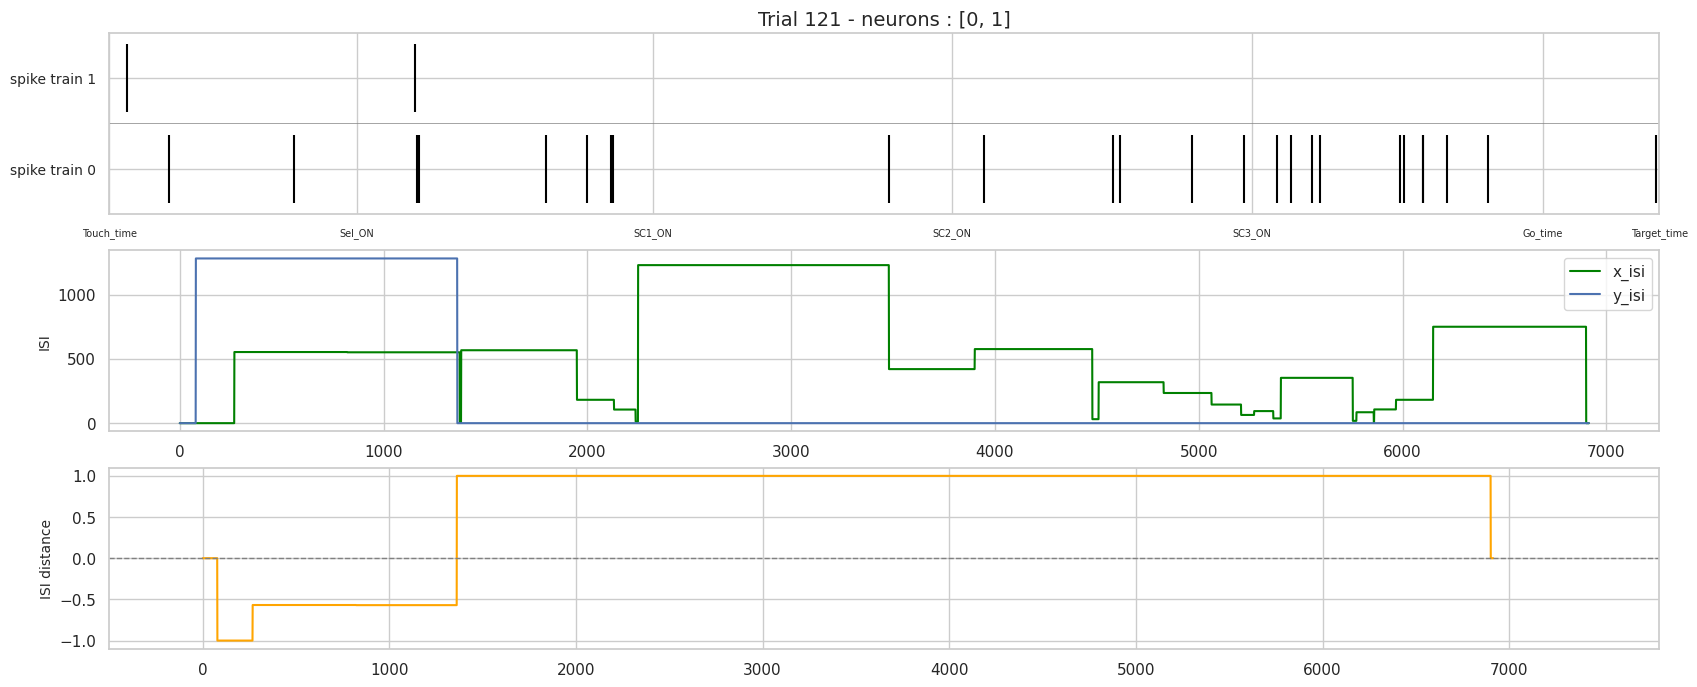

In [ ]:
t = 120
neurons_ = [0,1]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3,1, figsize=(20, 8))
sns.despine()
# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')
for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)


x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)


# Create a figure with two subplots
# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color = 'green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()
0
# Plot isi_dist in the second column
axs[2].plot(ISI_distance_interp[t,:,0], color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_interp[t,:,0].shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_interp[t,:,0].shape[0] + 500)  # Set x-axis limits



In [ ]:
t = 121
neurons_ = [0,1]
event_vector = df_task_ts.loc[t]

fig, axs = plt.subplots(3, 1, figsize=(20, 8))
sns.despine()

# Parcourir tous les neurones et tracer leur spike train
for idx, n in enumerate(neurons_) :
    spiketrain = spikes_times_aligned[n][t]['spike_train']

    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        axs[0].eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=idx, color='black')

for i in range(len(neurons_) - 1):
    axs[0].hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
axs[0].set_xticks(event_vector.values)
axs[0].set_xticklabels(event_labels, fontsize=7)
axs[0].set_yticks(range(n_neurons))
axs[0].set_yticklabels([f"spike train {n}" for n in range(n_neurons)], fontsize=10)
axs[0].set_title(f"Trial {t} - neurons : {neurons_}", fontsize=14)

# Ajuster les limites des axes
axs[0].set_xlim(event_vector.min(), event_vector.max())
axs[0].set_ylim(-0.5, len(neurons_)-0.5)

x_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[0]][t])
y_isi_in_time = ISI.compute(spikes_times_aligned[neurons_[1]][t]) 
ISI_distance_ = ISI.distance(x_isi_in_time, y_isi_in_time)

# Plot x_isi and y_isi in the first column
axs[1].plot(x_isi_in_time, color='green', label='x_isi')
axs[1].plot(y_isi_in_time, label='y_isi')
axs[1].set_ylabel('ISI', fontsize=10)
axs[1].legend()

# Plot isi_dist in the second column
axs[2].plot(ISI_distance_interp[t,:,0], color='orange')
axs[2].set_ylabel('ISI distance', fontsize=10)
axs[2].hlines(0, xmin=-500, xmax=ISI_distance_interp[t,:,0].shape[0]+ 500, colors='gray', linestyles='dashed', linewidth=1)
axs[2].set_xlim(-500, ISI_distance_interp[t,:,0].shape[0] + 500)  # Set x-axis limits

# Remove gridlines from all subplots
for ax in axs:
    ax.grid(False)

plt.show()


# Classif 

In [62]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

In [63]:
# Build pipeline
# Build pipeline
n_splits = 5
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
scaler = StandardScaler()
estimator = HistGradientBoostingClassifier()
clf = make_pipeline(scaler, estimator)

In [79]:
target = pd.DataFrame(target_info[completeUnit][1]['Trial_type'], columns=['trial_type'])
target['position'] = list_position[completeUnit]

n_times = list(np.arange(0, ISI_distance_interp.shape[1], 100))
n_bins = len(n_times)

In [80]:
# Initialiser une liste vide pour stocker les moyennes de bin
ISI_mean_bin = []

# Calculer les moyennes pour chaque bin et chaque paire
for start, end in zip(n_times[:-1], n_times[1:]):
    # Extraire les données pour le bin actuel
    bin_data = ISI_distance_interp[:, start:end, :]
    # Calculer la moyenne sur l'axe des temps
    bin_mean = np.nanmean(bin_data, axis=1)
    # Convertir les moyennes en DataFrame et les ajouter à la liste
    bin_mean_df = pd.DataFrame(bin_mean)
    ISI_mean_bin.append(bin_mean_df)

/tmp/ipykernel_13212/3111015751.py:9: RuntimeWarning: Mean of empty slice
  bin_mean = np.nanmean(bin_data, axis=1)


In [81]:
class Model_info:

    def __init__(self, n_splits, n_events, data, target, cvs, clf):
        self.n_splits = n_splits
        self.n_periods = n_events
        self.data = data
        self.target = target
        self.cvs = cvs
        self.clf = clf

In [82]:
list_ID_model = []

for idx, t in enumerate(n_times[:-1]):
    model_ID = Model_info(n_splits,\
             n_bins, ISI_mean_bin[idx], target['position'], cvs0, clf)
    list_ID_model.append(model_ID)

In [83]:
list_ID_model[0].target

0      2
1      2
2      3
3      3
4      4
      ..
171    3
172    3
173    4
174    4
175    4
Name: position, Length: 176, dtype: uint8

In [69]:
list_ID_model[1].data

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
0,0.00,0.00,0.0,0.0,0.0,0.00,0.00,-1.00,0.0,0.00,...,0.094816,1.00,-0.298557,1.0,0.65,-0.389189,0.65,-1.00,0.00,1.00
1,0.00,-0.94,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.00,...,1.000000,1.00,0.298372,1.0,0.00,-0.420000,0.00,-0.42,0.00,0.42
2,0.00,-0.50,0.0,0.0,0.0,0.00,0.00,-1.00,0.0,0.00,...,-0.459308,1.00,0.036707,1.0,1.00,0.548097,1.00,-1.00,0.00,1.00
3,0.00,-0.57,0.0,0.0,0.0,0.00,0.00,-0.34,0.0,0.00,...,-0.571807,1.00,-0.292427,1.0,1.00,0.225597,1.00,-1.00,0.00,1.00
4,0.00,-1.00,0.0,0.0,0.0,0.00,0.00,-1.00,0.0,0.00,...,-0.309942,1.00,0.008475,1.0,1.00,0.315790,1.00,-1.00,0.00,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,-1.00,-1.00,0.0,0.0,0.0,0.00,-0.72,0.00,0.0,0.00,...,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.00,0.00
172,-0.48,-1.00,0.0,0.0,0.0,0.00,-0.78,0.00,0.0,-0.34,...,0.000000,0.00,0.000000,0.0,0.00,0.000000,0.00,0.00,0.00,0.00
173,0.00,0.00,0.0,0.0,0.0,-1.00,-1.00,0.00,0.0,-0.75,...,0.000000,-0.95,0.000000,0.0,-0.95,0.000000,0.00,0.95,0.95,0.00
174,-1.00,-0.01,0.0,0.0,0.0,-0.06,-0.73,0.00,0.0,0.00,...,0.000000,-1.00,0.000000,0.0,-1.00,0.000000,0.00,1.00,1.00,0.00


In [89]:
acc_df = pd.DataFrame(columns=['split', 'data_type', 'time', 'target_type', 'accuracy'])
data_ = list_ID_model[0].data
target_ = list_ID_model[0].target
for i_split, (train_ind, test_ind) in enumerate(cvs0.split(data_, target_)):
    print('#################')
    print('SPLIT :', i_split)
    print('##################')
    
    for idx, t in enumerate(n_times[:-1]):
        model = list_ID_model[idx]
        data = model.data
        target = model.target

        # Train classifier 
        model.clf.fit(data.loc[train_ind, :], target.loc[train_ind].values.ravel())
    
        # Test classifier 
        y_pred = model.clf.predict(data.loc[test_ind, :])
        y_true = target.loc[test_ind].values
        acc = model.clf.score(data.loc[test_ind,:], target_.loc[test_ind])

        # Save test performance
        d = {
            'split': i_split,
            'data_type': 'test',
            'time': [t],
            'target_type': target.name, 
            'accuracy': acc,
        }

        acc_df = pd.concat((acc_df, pd.DataFrame(data=d)))
    
        # Train classifier on shuffled data
        ind_train_shuf = np.random.permutation(train_ind)
        model.clf.fit(data.loc[train_ind, :], target.loc[ind_train_shuf].values.ravel())
    
        # Test classifier on shuffled data
        y_pred_shuf = model.clf.predict(data.loc[test_ind, :])
        acc_shuf = model.clf.score(data.loc[test_ind,:], target_.loc[test_ind])
        
        # Save shuffled performance
        d_shuff = {
            'split': i_split,
            'data_type': 'shuff',
            'time': [t],
            'target_type': target.name, 
            'accuracy': acc_shuf
        }
        acc_df = pd.concat((acc_df, pd.DataFrame(data=d_shuff)), ignore_index=True)


#################
SPLIT : 0
##################


/tmp/ipykernel_13212/762959843.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  acc_df = pd.concat((acc_df, pd.DataFrame(data=d)))


#################
SPLIT : 1
##################
#################
SPLIT : 2
##################
#################
SPLIT : 3
##################
#################
SPLIT : 4
##################


In [90]:
acc_df.to_csv(f'{result_path}/{session}_{classif}_{measure}_position.csv')

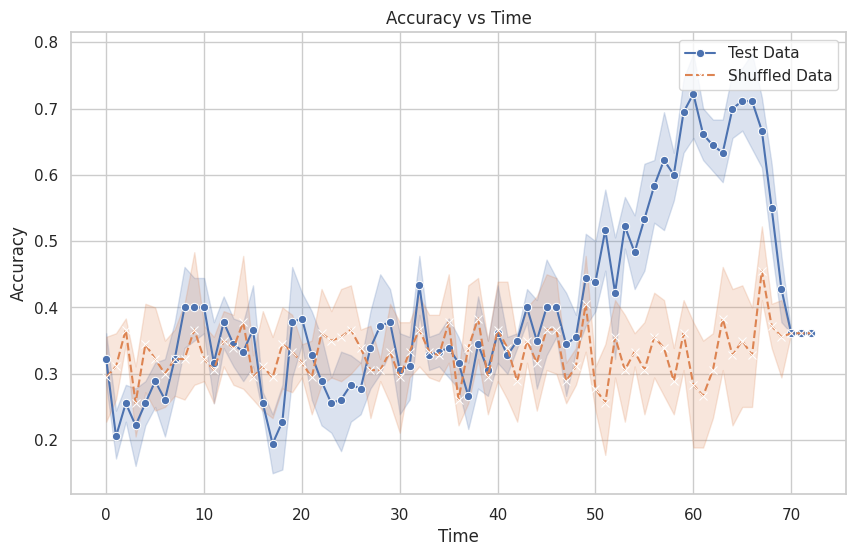

In [85]:
import seaborn as sns
import matplotlib.pyplot as plt

# Séparez les données par type
test_data = acc_df[acc_df['data_type'] == 'test']
shuff_data = acc_df[acc_df['data_type'] == 'shuff'] 

# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les données
plt.figure(figsize=(10, 6))

# Tracer les données de test
sns.lineplot(data=test_data, x='time', y='accuracy', marker='o', linestyle='-', label='Test Data')

# Tracer les données de shuffled
sns.lineplot(data=shuff_data, x='time', y='accuracy', marker='x', linestyle='--', label='Shuffled Data')

# Définir les étiquettes d'axe et le titre
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Time')

# Afficher la légende
plt.legend()

# Afficher le tracé
plt.show()
